In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as mpl
import pyspark as ps
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.context import SQLContext
from pandas.core.frame import DataFrame as PDataFrame

%matplotlib inline

In [2]:
def quartiles_resolver(df:DataFrame, col:str)->type(tuple):
    ordered_df = df.orderBy(col)
    count = ordered_df.count()
    quot = count >> 1
    rem = count % 2
    m_index = quot if rem == 0 else quot + rem
    p_df = ordered_df.select('*').toPandas()
    q1 = p_df[col][m_index - 1 :].mean()
    q2 = p_df[col][m_index]
    q3 = p_df[col][: m_index].mean()
    return (q1, q2, q3, p_df)

def interquartile_infos(df:DataFrame, col:str)->type(tuple):
    q1, q2, q3, p_df = quartiles_resolver(df, col)
    v_min = p_df[col].min()
    v_max = p_df[col].max()
    v_med = p_df[col].mean()
    return v_min, v_max, v_med, q1, q2, q3, p_df

In [3]:
s = ps.sql.SparkSession.builder\
    .master('local[4]')\
    .appName('spark-ml')\
    .getOrCreate()

In [4]:
df = SQLContext(s.sparkContext).read.csv(
    path='data.csv',
    header=True,
    quote='"',
    sep=",",
    inferSchema=True
)

In [5]:
filtered_df = df[[
    'ID',
    'Name',
    'Age',
    'Nationality',
    'Overall',
    'Potential',
    'Club',
    'Value',
    'International Reputation',
    'Release Clause'
]]

In [6]:
filtered_df.show(5)

+------+-----------------+---+-----------+-------+---------+-------------------+-------+------------------------+--------------+
|    ID|             Name|Age|Nationality|Overall|Potential|               Club|  Value|International Reputation|Release Clause|
+------+-----------------+---+-----------+-------+---------+-------------------+-------+------------------------+--------------+
|158023|         L. Messi| 31|  Argentina|     94|       94|       FC Barcelona|€110.5M|                       5|       €226.5M|
| 20801|Cristiano Ronaldo| 33|   Portugal|     94|       94|           Juventus|   €77M|                       5|       €127.1M|
|190871|        Neymar Jr| 26|     Brazil|     92|       93|Paris Saint-Germain|€118.5M|                       5|       €228.1M|
|193080|           De Gea| 27|      Spain|     91|       93|  Manchester United|   €72M|                       4|       €138.6M|
|192985|     K. De Bruyne| 27|    Belgium|     91|       92|    Manchester City|  €102M|         

In [7]:
min_scr, max_scr, median, q1, q2, q3, filtered_p_df = interquartile_infos(filtered_df, 'Age')

min: 16
max: 45
median: 25.122205745043114 (IQR: 25)
lower quartile: 28.967157293497365
upper quartile: 21.27724077328647


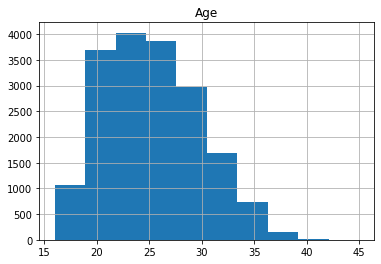

In [8]:
filtered_p_df.hist(['Age'])
print("min: {}".format(min_scr))
print("max: {}".format(max_scr))
print("median: {} (IQR: {})".format(median, q2))
print("lower quartile: {}".format(q1))
print("upper quartile: {}".format(q3))
mpl.show()

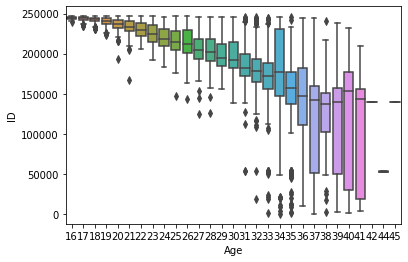

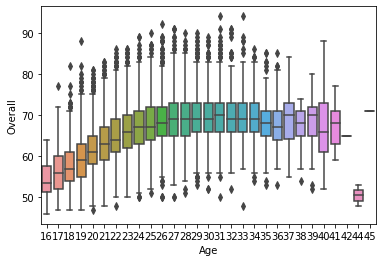

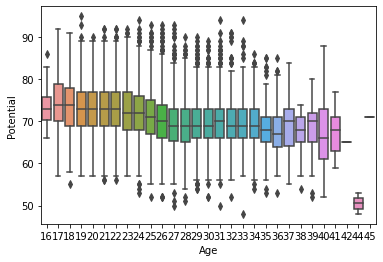

In [9]:
ax = sns.boxplot(x=filtered_p_df['Age'], y=filtered_p_df['ID'])
mpl.show()
ax = sns.boxplot(x=filtered_p_df['Age'], y=filtered_p_df['Overall'])
mpl.show()
ax = sns.boxplot(x=filtered_p_df['Age'], y=filtered_p_df['Potential'])
mpl.show()